# Data exploration
Explore the temporal structure of production data of renewable by center, technology (solar, wind, hydro, etc.), identify basic patterns, evaluate the quality of weather data, and detect possible relationship between climate variables, technology type of technology, demand and production


## Imports


### Third party packages


In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


### First party modules


In [2]:
# Get the project root
ROOT_DIR = Path.cwd().parent
sys.path.append(str(ROOT_DIR))

In [3]:
from src.data import filter_by_date_range, make_date_columns  # type: ignore


### Optional packages

In [4]:
try:
    from catppuccin import PALETTE  # Just for aesthetic proposes
    catppuccin_imported = True
except ImportError:
    print("The catppuccin package is not installed, no matter :), plots will use the default visual configuration.")
    catppuccin_imported = False

In [5]:
if catppuccin_imported:
    # Choose a flavor (latte, frappe, macchiato, mocha)
    flavor = PALETTE.mocha

    # Extract colors as hex values in a dict for easy access
    colors = {color.name.lower().replace(' ', '_'): color.hex for color in flavor.colors}

    # Define color cycle for plots (select the colors you want to use)
    color_cycle = [
        colors['blue'], colors['red'], colors['green'], 
        colors['yellow'], colors['pink'], colors['teal'],
        colors['peach'], colors['mauve'], colors['lavender']
    ]

    # Configure matplotlib
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_cycle)
    plt.rcParams['axes.facecolor'] = colors['base']
    plt.rcParams['figure.facecolor'] = colors['mantle']
    plt.rcParams['text.color'] = colors['text']
    plt.rcParams['axes.labelcolor'] = colors['text']
    plt.rcParams['xtick.color'] = colors['subtext_1'] 
    plt.rcParams['ytick.color'] = colors['subtext_1']
    plt.rcParams['axes.edgecolor'] = colors['surface_2']
    plt.rcParams['grid.color'] = colors['surface_0']

    # Configure seaborn
    sns.set_palette(color_cycle)
    sns.set_style({
        'axes.facecolor': colors['base'],
        'figure.facecolor': colors['mantle'],
        'text.color': colors['text'],
        'axes.labelcolor': colors['text'],
        'xtick.color': colors['subtext_1'],
        'ytick.color': colors['subtext_1'],
        'axes.edgecolor': colors['surface_2'],
        'grid.color': colors['surface_0']
    })

## Data


### Load data

In [6]:
# Change for "../data/raw/daily_energy_production.csv" for a classic path
data_path = ROOT_DIR / "data" / "raw"
historic_data_path = ROOT_DIR / "data" / "processed" / "csv_files"

demand_path = data_path / "hourly_demand.csv"
generation_path = data_path / "hourly_generation.csv"
historic_data_path_csv = historic_data_path / "2025-1.csv"

historic = pd.read_csv(historic_data_path_csv)
demand = pd.read_csv(demand_path)
generation = pd.read_csv(generation_path)

### Format data

In [7]:
# Rename columns with more readable names
demand = demand.rename(
    columns={
        "fecha": "date",
        "hora": "hour",
        "demanda": "demand",
    },
)
generation = generation.rename(
    columns={
        "Fecha y Hora": "datetime",
        "Tipo Tecnología": "tech_type",
        "Generación Real (MWh)": "generation_mwh",
    },
)

In [8]:
# Convert date columns to datetime
generation["datetime"] = pd.to_datetime(generation["datetime"])
demand["date"] = pd.to_datetime(demand["date"])
historic["fecha_opreal"] = pd.to_datetime(historic["fecha_opreal"])

# Add date columns
generation_processed = make_date_columns(generation, "datetime", use_24_hour=True)
demand_processed = make_date_columns(demand, "date", components=["year", "month", "day"])
historic = make_date_columns(historic, "fecha_opreal", components=["year", "month", "day"])

# Add date to align with the demand `date` and drop the unnecessary `datetime`
generation_processed["date"] = pd.to_datetime(generation_processed["datetime"].dt.date)
generation_processed = generation_processed.drop(columns="datetime")

In [9]:
demand_processed["hour"].value_counts().sort_index()

hour
1     3646
2     3654
3     3654
4     3654
5     3654
6     3654
7     3654
8     3654
9     3654
10    3654
11    3654
12    3654
13    3654
14    3654
15    3654
16    3654
17    3654
18    3654
19    3654
20    3654
21    3654
22    3654
23    3654
24    3654
25       9
Name: count, dtype: int64

There is 9 values for 25, that is inconsistent with the 24 hours at the day. Also, the hour 1 have 8 values less than the others, this could be because of hour changes in Chile. So a possible approach could be convert these nine 25 values to 1 instead.

In [10]:
# Convert hour outliers (25 hour to 1)
demand_processed["hour"] = demand_processed["hour"].replace(25, 1)
# Convert demand values to float
demand_processed["demand"] = pd.to_numeric(demand_processed["demand"].str.replace(",", "."))

### Data Wrangling

In [11]:
demand_processed = demand_processed.rename(columns={"date": "fecha_opreal", "hour": "hora_opreal"})

In [12]:
start_date = "2025-01-01"
end_date = "2025-04-23"

demand_ranged = filter_by_date_range(demand_processed, "fecha_opreal", start_date, end_date)
generation_ranged = filter_by_date_range(historic, "fecha_opreal", start_date, end_date)

In [13]:
granularity = ["fecha_opreal", "hora_opreal"]
energy_sources = historic["central_tipo_nemotecnico"].unique()

demand_grouped = demand_ranged.groupby(by=granularity)[["demand"]].sum().reset_index()
generation_grouped = generation_ranged.groupby(by=[*granularity, "central_tipo_nemotecnico", "subtipo_nemotecnico"])[["generacion_real_mwh"]].sum().reset_index()

# NOTE: actually the hour is the hour_real - 1 for datetime consistency, but could change 
generation_grouped['datetime'] = generation_grouped.apply(lambda row: row['fecha_opreal'].replace(hour=int(row['hora_opreal'])-1), axis=1)

In [14]:
merged = generation_grouped.merge(demand_grouped, how="inner", on=["fecha_opreal", "hora_opreal"])

In [15]:
pivot_generation = generation_grouped.pivot_table(
    index=["datetime"],
    columns="central_tipo_nemotecnico",
    values="generacion_real_mwh",
    aggfunc="sum",
).reset_index()
pivot_generation["ernc"] = pivot_generation["solar"] + pivot_generation["eolica"] + pivot_generation["geotermica"]

## Visualization

### Gross time series

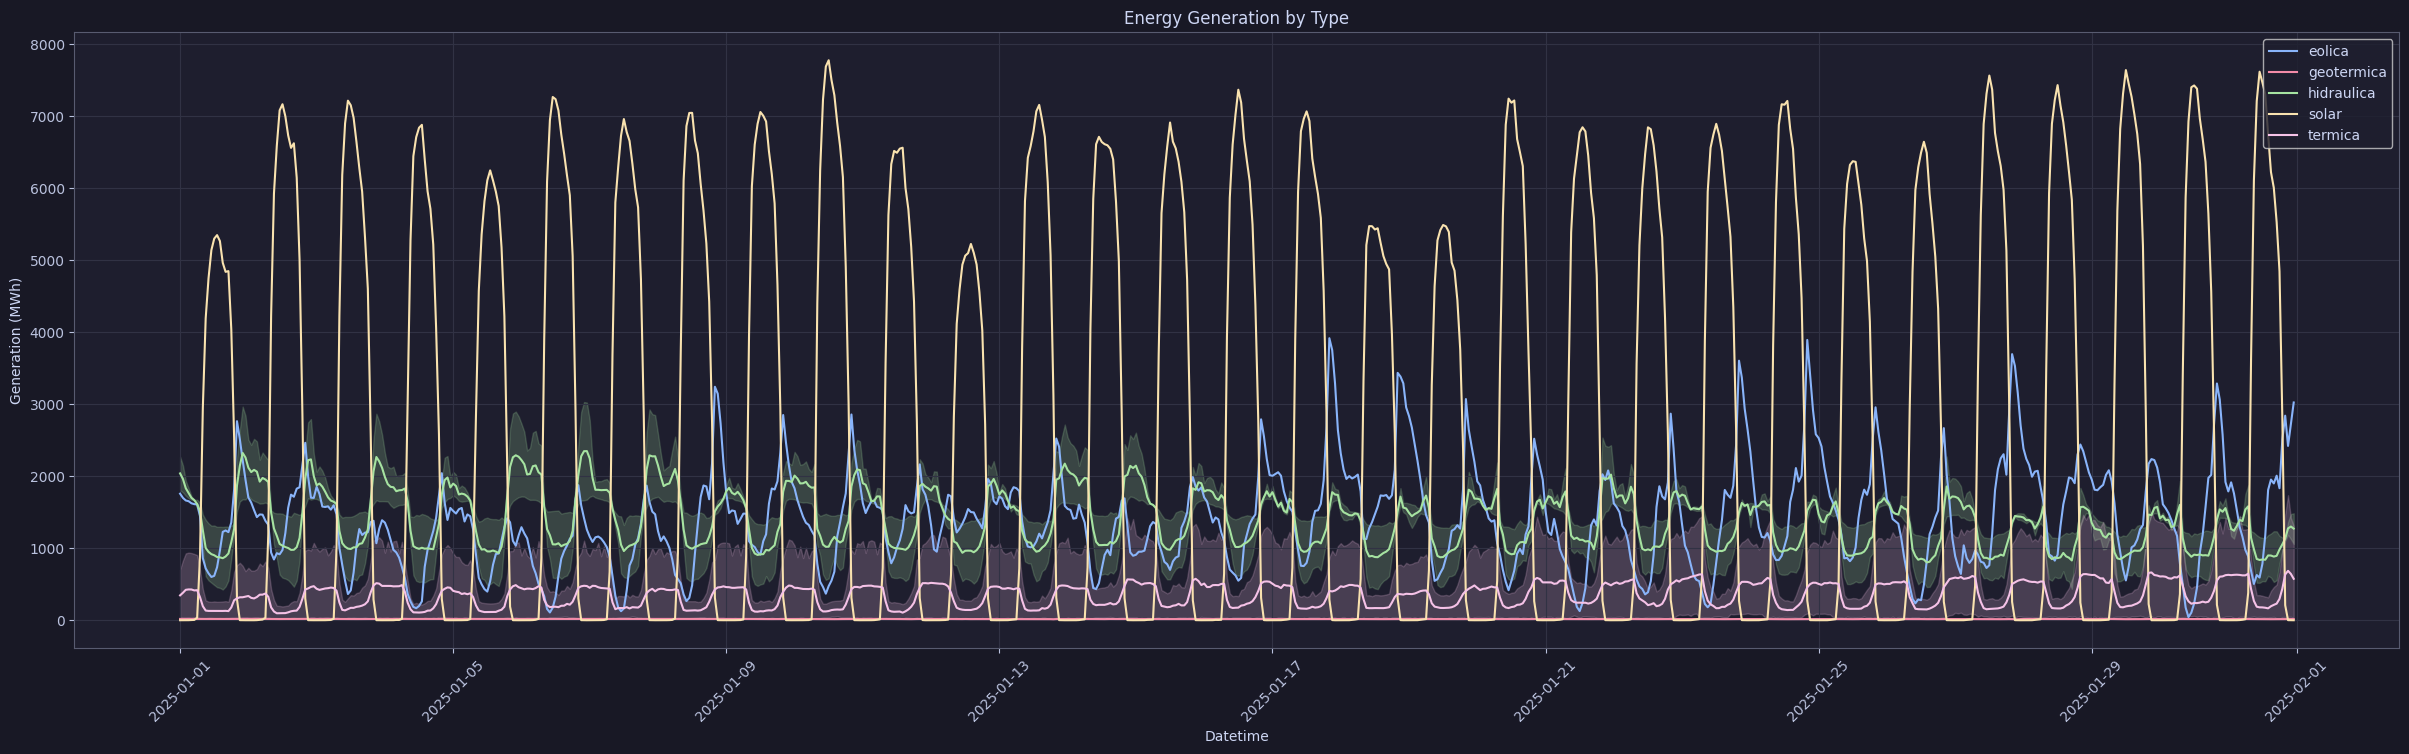

In [16]:
plt.figure(figsize=(30, 8))
sns.lineplot(merged, x="datetime", y="generacion_real_mwh", hue="central_tipo_nemotecnico")

plt.xlabel("Datetime")
plt.ylabel("Generation (MWh)")
plt.title("Energy Generation by Type")
plt.legend(loc="upper right")
plt.xticks(rotation=45)
plt.grid(True)

### Hourly variation

In [17]:
pivot_hour_generation = (
    historic.pivot_table(
        index=["fecha_opreal", "hora_opreal"],
        columns="central_tipo_nemotecnico",
        values="generacion_real_mwh",
        aggfunc="sum",
    )
    .reset_index()
    .groupby("hora_opreal")[historic["central_tipo_nemotecnico"].unique().tolist()]
    .sum()
    .reset_index()
)

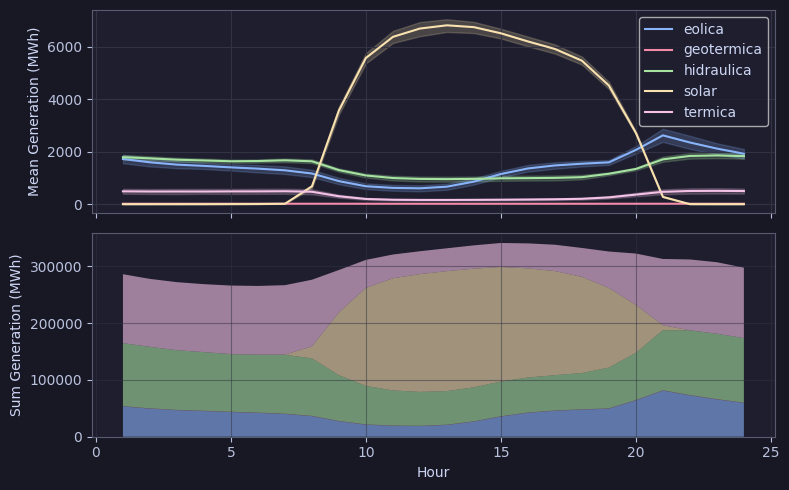

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 5), sharex=True)

# First subplot (lineplot)
sns.lineplot(
    data=generation_grouped,
    x="hora_opreal",
    y="generacion_real_mwh",
    hue="central_tipo_nemotecnico",
    ax=ax1,
)
ax1.set_xlabel("")
ax1.set_ylabel("Mean Generation (MWh)")
ax1.legend(loc="upper right")
ax1.grid(True)

# Second subplot (stackplot)
ax2.stackplot(
    pivot_hour_generation["hora_opreal"],
    pivot_hour_generation["eolica"],
    pivot_hour_generation["geotermica"],
    pivot_hour_generation["hidraulica"],
    pivot_hour_generation["solar"],
    pivot_hour_generation["termica"],
    labels=["Eoilica", "Geotermica", "Hidraulica", "Solar", "Hidraulica"],
    alpha=0.6,
)
ax2.set_xlabel("Hour")
ax2.set_ylabel("Sum Generation (MWh)")
ax2.grid(True, alpha=0.5)

# Adjust layout to prevent overlapping
plt.tight_layout()

plt.show()

### Boxplot by granularity

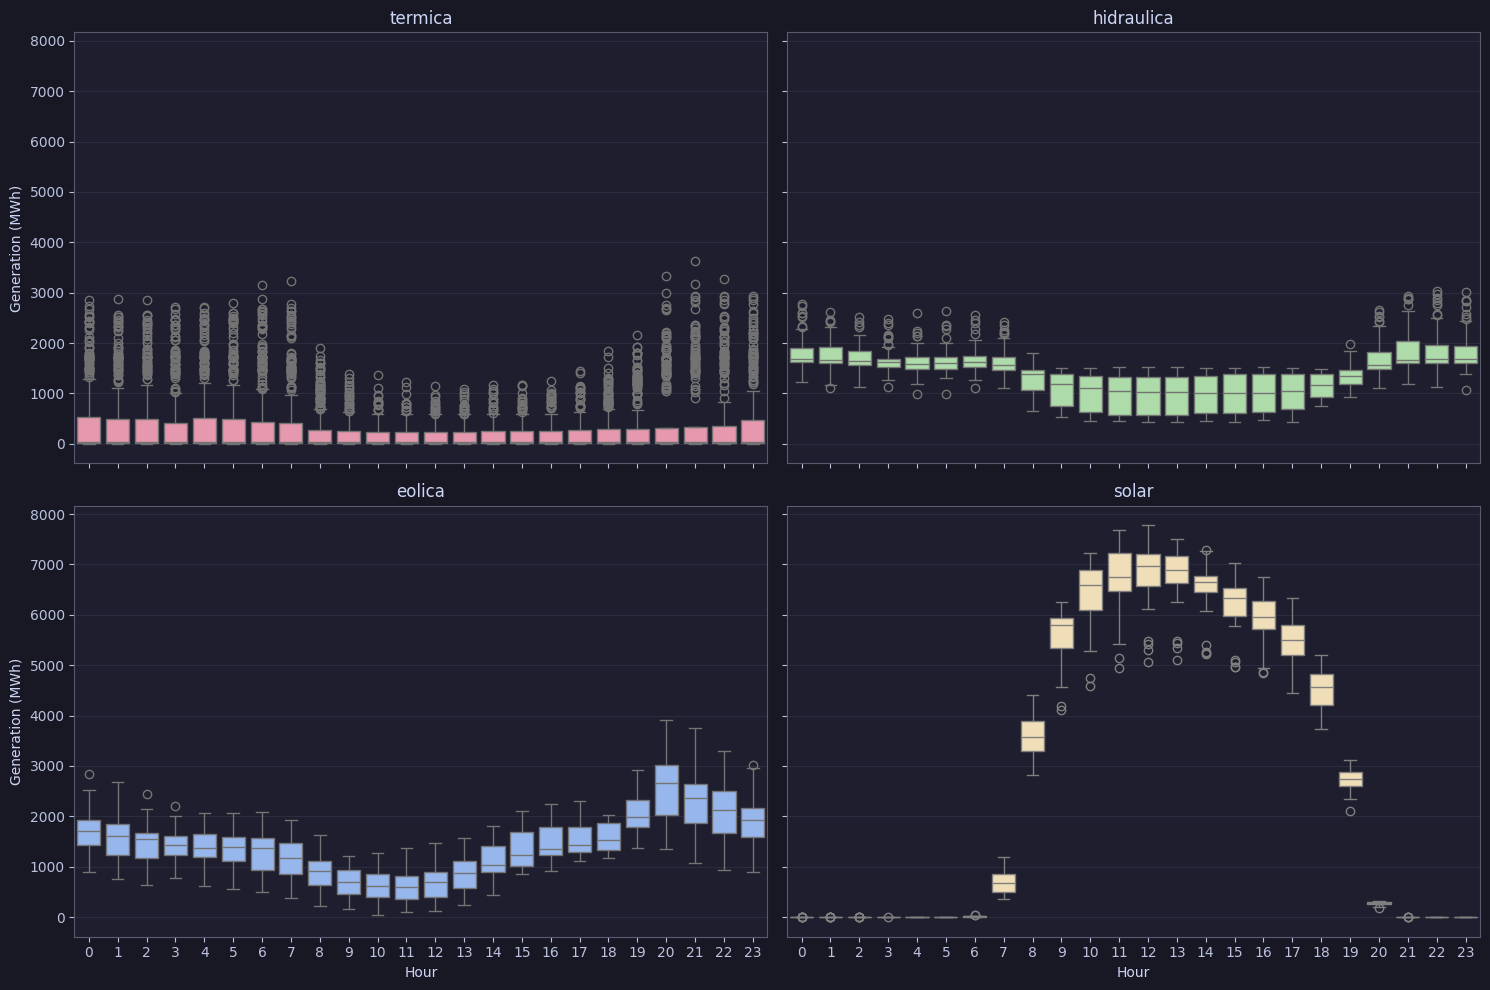

In [44]:
selected_types = ["termica", "hidraulica", "eolica", "solar"]

type_colors = {
    "termica": colors["red"],
    "hidraulica": colors["green"],
    "eolica": colors["blue"],
    "solar": colors["yellow"],
    "geotermica": colors["mauve"],
}

num_cols = 2
num_rows = (len(selected_types) + num_cols - 1) // num_cols

fig, axes = plt.subplots(
    num_rows, num_cols, figsize=(15, 5 * num_rows), sharex=True, sharey=True
)
axes = axes.flatten()

# Iterate through the selected types and create a boxplot for each
for i, category in enumerate(selected_types):
    if category in generation_grouped["central_tipo_nemotecnico"].unique():
        subset_df = generation_grouped[
            generation_grouped["central_tipo_nemotecnico"] == category
        ]

        sns.boxplot(
            data=subset_df,
            y="generacion_real_mwh",
            x=subset_df["datetime"].dt.hour,
            color=type_colors[category],
            ax=axes[i],
        )

        axes[i].set_title(f"{category}")
        axes[i].set_xlabel("Hour")
        axes[i].set_ylabel("Generation (MWh)")
        axes[i].grid(axis="y", alpha=0.7)
    else:
        # If the type is not found in the data, remove the corresponding subplot
        fig.delaxes(axes[i])

# Remove any remaining unused subplots
for j in range(len(selected_types), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Correlation Heatmap

In [20]:
pivot_2 = historic.pivot_table(
    index=["fecha_opreal", "hora_opreal"],
    columns="central_tipo_nemotecnico",
    values="generacion_real_mwh",
    aggfunc="sum",
)

Text(0.5, 1.0, 'Correlation between Generation Technologies')

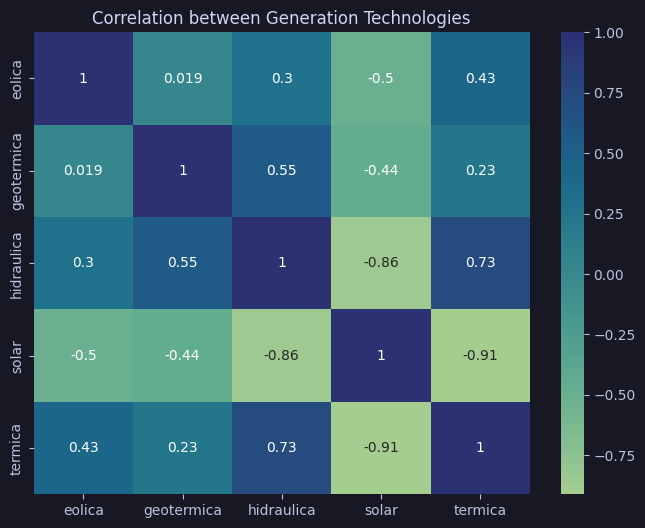

In [31]:
correlations_df = pivot_2.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlations_df, annot=True, cmap="crest")

plt.xlabel("")
plt.ylabel("")
plt.title("Correlation between Generation Technologies")